# Results from WandB


## Imports

In [1]:
import wandb
from community.utils.wandb_utils import get_wandb_artifact, get_wandb_runs
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns
import pandas as pd
import numpy.linalg as LA
from itertools import product
import ipywidgets as widgets
import os


## Load Results

In [3]:
local_save = True

sweep_path = "gbena/funcspec/mjw4dzu9"
sweep_path = "m2snn/funcspec_V2/lf31u7wy"
sweep_path = "m2snn/funcspec_V2/etsyghun"
sweep_path = "m2snn/funcspec_V2/y1n0vtbp"
sweep_path = "m2snn/funcspec_V2/if1h3qpo"
sweep_path = "m2snn/funcspec_V2/o90n8wvw"
sweep_path = "m2snn/funcspec_V2/t3avf3g4"
sweep_path = "m2snn/funcspec_V2/0cwq0u1o"
sweep_path = "m2snn/funcspec_V2/1irwkxuo"
sweep_path = "m2snn/funcspec_V2/v0lh66o3"
sweep_path = "m2snn/funcspec_V2/j8e1s14e"
sweep_path = "m2snn/funcspec_V2/zq7n9zq4"
sweep_path = "m2snn/funcspec_V2/b275wyza"
sweep_path = "m2snn/funcspec_V2/4mo83a0n"
sweep_path = "m2snn/funcspec_V2/ctkkpstr"
sweep_path = "m2snn/funcspec_V2/oiu3w3pz"
sweep_path = "m2snn/funcspec_V2/47hzr78g"

sweep_id = sweep_path.split("/")[-1]

if not local_save:

    try:
        total_data = pd.read_pickle(f"../../results/sweep_tables/{sweep_id}")
    except FileNotFoundError:
        total_data = pd.read_pickle(
            f"../../results/sweep_tables/MetricResults_{sweep_id}"
        )
else:
    total_data = pd.read_pickle(
        f"/mnt/storage/gb21/compiled_wandb_results/compiled/{sweep_id}/metric_table"
    )

total_data.head()

,Unnamed: 0,Step,best_acc,sparsity,common_input,common_readout,cov_ratio,n_bot,n_hidden,task,...,correlations_global_diff,correlations_0_local_diff,correlations_1_local_diff,ablations_det,ablations_det_col_norm,ablations_global_diff,ablations_0_local_diff,ablations_1_local_diff,seed,name
0,0,mid-,0.948251,0.0,True,True,1.0,NaN,34,family,...,0.189559,-0.148160,0.230957,0.000000,0.000000,0.000000,0.113332,0.113332,240,00yi58a0
1,1,last,0.948251,0.0,True,True,1.0,NaN,34,family,...,0.063993,0.077566,0.205551,0.029718,0.112439,0.112612,0.080458,-0.144766,240,00yi58a0
2,0,mid-,0.955028,0.0,True,True,1.0,NaN,34,family,...,0.087102,0.173810,-0.000394,0.000000,0.000000,0.000000,0.110513,0.110513,240,00yi58a0
3,1,last,0.955028,0.0,True,True,1.0,NaN,34,family,...,0.190523,-0.303448,0.077599,0.010224,0.034757,0.034858,0.122331,0.052614,240,00yi58a0
4,0,mid-,0.963375,0.0,True,True,1.0,NaN,34,family,...,0.146664,-0.090794,0.202535,0.000000,0.000000,0.000000,0.015841,0.015841,240,00yi58a0


In [25]:
def filter_data(data, v_params):
    data = data.copy()
    for key, value in v_params.items():
        if value is None:
            data = data[data[key].isnull()]
        else:
            data = data[data[key] == value]

    return data


def get_values(data, x="n_hidden", y="sparsity", value="retraining_global_diff"):
    return data[[x, y, value]].values.T


def get_all_v_params(varying_params, excluded_params={}):
    return [
        {
            k: p
            for k, p in zip(varying_params.keys(), params)
            if k not in excluded_params
        }
        for params in product(*varying_params.values())
    ]


varying_params = {
    "common_readout": [True],
    "n_bot": [None],
    "common_input": [True, False],
    "task": ["family"],
    "Step": ["mid-", "last"],
    #"cov_ratio": [0.01, 0.05, 0.10, 0.5, 1],
}

heatmap_params = ["n_hidden", "sparsity", "cov_ratio"]

In [26]:
total_data["mult"] = total_data["retraining_global_diff"] * total_data["best_acc"]


## Plot Interactive Sweep Results

In [27]:
from community.utils.heatmap import compute_and_plot_heatmap, compute_and_plot_colormesh

In [32]:
varying_params_all = get_all_v_params(varying_params)


def plot_fn(**params):

    plot_type = params.pop("plot_type")
    metric = params.pop("metric_to_plot")
    smoothness = params.pop("smoothness")
    log_scale = params.pop("log_scale")
    x, y = params.pop("x"), params.pop("y")

    v_params = {k: v for k, v in params.items()}
    print(v_params)
    # print(v_params)
    excluded_params = {"Step", "task"}
    v_params_filered = {k: v for k, v in params.items() if k not in excluded_params}
    legend_params = {k: v for k, v in v_params_filered.items() if len(v) != 1}

    tasks, steps = v_params["task"], v_params["Step"]

    n_tasks = len(tasks)
    n_steps = len(steps)

    v_params_all = get_all_v_params(v_params_filered)
    legend_params_all = get_all_v_params(legend_params)

    if plot_type == "grad_spec":
        pass

    else:
        for s, step in enumerate(steps):

            v_p1 = len(v_params_filered)
            v_p2 = max([len(v) for v in v_params_filered.values()])

            n_params = len(v_params_all)
            n1 = int(np.sqrt(n_params))
            n2 = n_params // n1

            if n1 * n2 < n_params:
                n2 += 1

            # print(n1, n2)

            fig = plt.figure(
                constrained_layout=True, figsize=(5 * n2, 5 * n1 * n_tasks)
            )

            fig.suptitle(f"Functional Specialization on step {step}")

            # create 3x1 subfigs
            subfigs = fig.subfigures(nrows=n_tasks, ncols=1)
            if n_tasks == 1:
                subfigs = [subfigs]

            Zs = []

            for t, (subfig, task) in enumerate(zip(subfigs, tasks)):

                subfig.suptitle(f"Task :  {task}")

                # create subplots per subfig

                axs = subfig.subplots(nrows=n1, ncols=n2)

                try:
                    axs[0]
                except TypeError:
                    axs = np.array([axs])
                for i, (ax, v_param, l_param) in enumerate(
                    zip(axs.flatten(), v_params_all, legend_params_all)
                ):

                    filter_param = v_param.copy()
                    filter_param["Step"] = step
                    filter_param["task"] = task
                    data = filter_data(total_data, filter_param)

                    argmins = (
                        data[metric].values.argsort()[:10],
                        data[metric].values.argsort()[-10:],
                    )
                    minmax = [data[metric].values[idxs].mean() for idxs in argmins]
                    # print(minmax)
                    # print(data.shape)
                    values = get_values(data, x, y, metric)

                    if 0 not in data.shape:
                        if plot_type == "heatmap":

                            (
                                (X, Y),
                                (X_mesh, Y_mesh),
                                Z,
                                sigmas,
                                *_,
                            ) = compute_and_plot_heatmap(
                                values,
                                (fig, ax),
                                log_scale=log_scale,
                                plot_f=False,
                                random=True,
                                minmax=minmax,
                                smoothness=smoothness,
                            )
                        elif plot_type == "scipy":
                            (
                                X_mesh,
                                Y_mesh,
                                Z,
                                (fig, ax),
                                cbar,
                            ) = compute_and_plot_colormesh(
                                values, (fig, ax), log_scale=log_scale
                            )

                        elif plot_type == "table":

                            grouped_values = data.groupby([x, y])[metric].mean()

                            x_values = data[x].unique()[::-1]
                            y_values = data[y].unique()
                            y_values_per_x = data.groupby(x)[y].unique()

                            # Z = np.array([[grouped_values[x][y] for y in y_values_per_x[x]] for x in x_values]).T
                            Z = pd.concat([grouped_values[x] for x in x_values], axis=1)
                            Z.columns = x_values

                            # print(Z)

                            im = ax.imshow(Z)
                            ax.set_xticks(range(len(x_values)))
                            ax.set_xticklabels(x_values.astype(str))
                            if y == "cov_ratio":
                                ax.set_yticks(range(len(y_values)))
                                ax.set_yticklabels(y_values.astype(str))
                            ax.set_xlabel(x)
                            ax.set_ylabel(y)
                            fig.colorbar(im, ax=ax)

                        Zs.append(Z)

                    ax.set_title((str(l_param).strip("{}").replace(",", "\n")))

In [33]:
params_widgets = {
    k: widgets.SelectMultiple(
        options=[p for p in params], description=k, disabled=False, value=[params[0]]
    )
    for k, params in varying_params.items()
    if (len(params) > 1 or k == "task")
}

params_widgets["smoothness"] = widgets.FloatSlider(7, min=0.5, max=10, step=0.2)
# params_widgets['epoch'] = widgets.IntSlider(nb_epochs-1, min=0, max=nb_epochs-1)
params_widgets["log_scale"] = widgets.Dropdown(options=[False, True])

params_widgets["plot_type"] = widgets.Dropdown(
    options=["heatmap", "scipy", "table"],
    description="Plot Type",
    disabled=False,
    manual=True,
    auto_display=False,
)

params_widgets["metric_to_plot"] = widgets.Dropdown(
    options=[
        "retraining_global_diff",
        "ablations_global_diff",
        "correlations_global_diff",
        "best_acc",
        "mult",
    ],
    description="Metric to plot",
    disabled=False,
    manual=True,
    auto_display=False,
)

params_widgets["x"] = widgets.Dropdown(
    options=heatmap_params[:-1],
    description="x-axis",
    disabled=False,
    manual=True,
    auto_display=False,
)

params_widgets["y"] = widgets.Dropdown(
    options=heatmap_params[1:],
    description="y-axis",
    disabled=False,
    manual=True,
    auto_display=False,
)
interactive_plot = widgets.interactive(plot_fn, **params_widgets)

In [34]:
display(interactive_plot)


interactive(children=(SelectMultiple(description='common_input', index=(0,), options=(True, False), value=(Tru…

## Heatmaps

In [129]:
data = filter_data(total_data, {"Step" : 'last', 'common_input' : False, 'n_bot' : None})

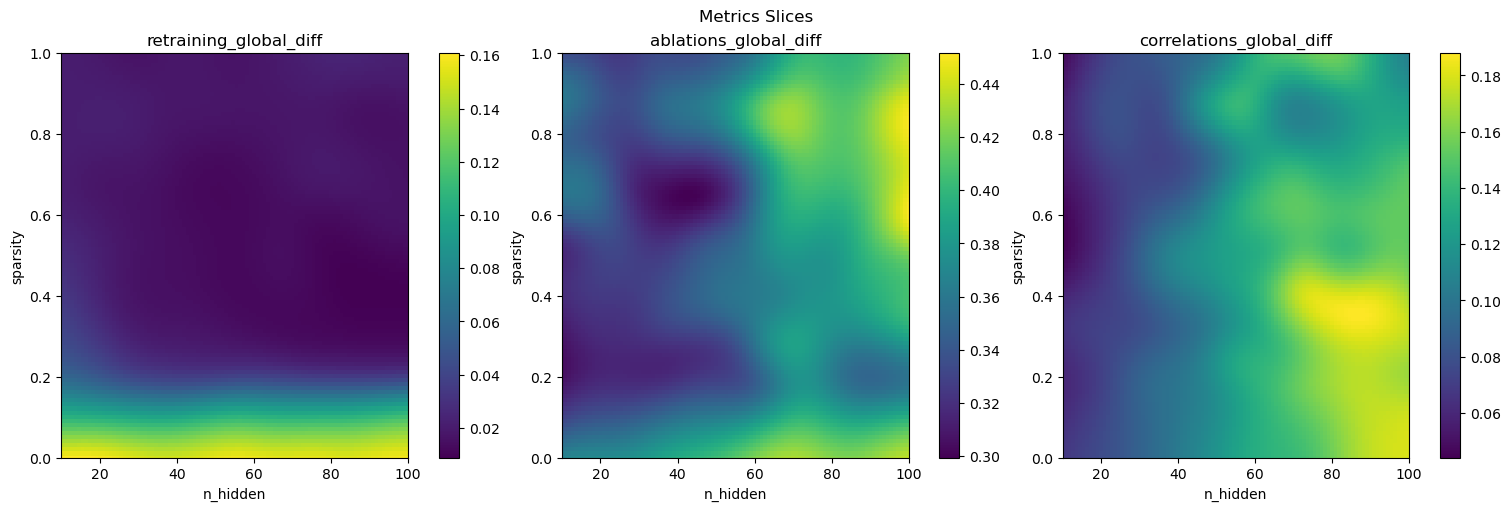

In [130]:
metrics = [
    "retraining_global_diff",
    "ablations_global_diff",
    "correlations_global_diff",
]

fig = plt.figure(constrained_layout=True, figsize=(15, 5))
fig.suptitle('Metrics Slices')
subfigs = fig.subfigures(nrows=1, ncols=1)
try : 
    subfigs[0]
except TypeError : 
    subfigs = [subfigs]
for m, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=3)
    try : 
        axs[0]
    except TypeError : 
        axs = [axs]
    for i, ax in enumerate(axs):

        x = heatmap_params[m]
        y = heatmap_params[(m + 1) % 3]
        values = get_values(data, x, y, metrics[i])

        ((X, Y), (X_mesh, Y_mesh), Z, sigmas, *_,) = compute_and_plot_heatmap(
            values,
            (fig, ax),
            log_scale=False,
            plot_f=False,
            random=True,
            smoothness=10,
        )

        ax.set_xlabel(x)
        ax.set_ylabel(y)

        ax.set_title(metrics[i])


In [123]:
path = '/mnt/storage/gb21/wandb_results/sweeps/47hzr78g/00yi58a0/'
train_outs = torch.load(path + 'training_results')

for k, v in train_outs[1].items() : 
    torch.save(v, path + 'training_results_all/' +  k)

In [124]:
len(train_outs)

215

In [119]:
import sys
{k : sys.getsizeof(v) for k, v in train_outs[0].items()}

{'train_losses': 112,
 'train_accs': 128,
 'test_losses': 312,
 'test_accs': 428,
 'deciding_agents': 112,
 'best_state': 1408}

In [102]:
data = filter_data(total_data, {"Step" : 'last', 'common_input' : True, 'n_hidden' : 10, 'cov_ratio' : 1})

<AxesSubplot: xlabel='sparsity', ylabel='retraining_global_diff'>

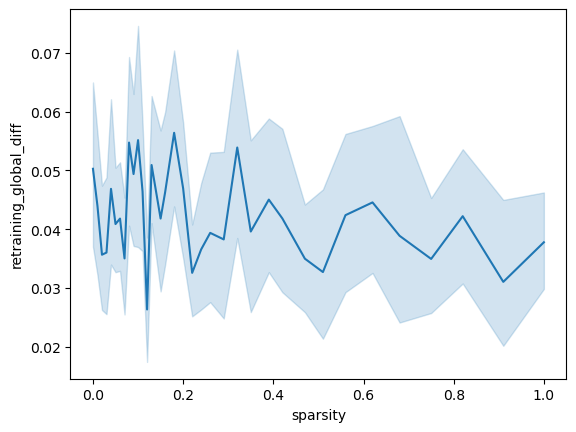

In [110]:
sns.lineplot(data=data, x='sparsity', y=metrics[0])

In [112]:
data['retraining_global_diff']

1      0.034062
3      0.062719
5      0.145590
7      0.053399
9      0.033349
         ...   
341    0.009290
343    0.017543
345    0.045065
347    0.018759
349    0.025721
Name: retraining_global_diff, Length: 875, dtype: float64

## Tables

In [36]:
x, y, metric = *heatmap_params[::2], "retraining_global_diff"

In [40]:
data = filter_data(total_data, {"Step" : 'last', 'common_input' : False})

In [62]:
x_values = data[x].unique()[::-1]
y_values = data[y].unique()
y_values_per_x = data.groupby(x)[y].unique()
grouped_values = data.groupby([x, y])[metric].mean()

z_dict = [
    {(xv, yv): grouped_values[xv][yv] for yv in y_values_per_x[xv]} for xv in x_values
]

In [68]:
z = pd.concat([grouped_values[x] for x in x_values], axis=1)
z.columns = x_values
z = z[sorted(x_values)]


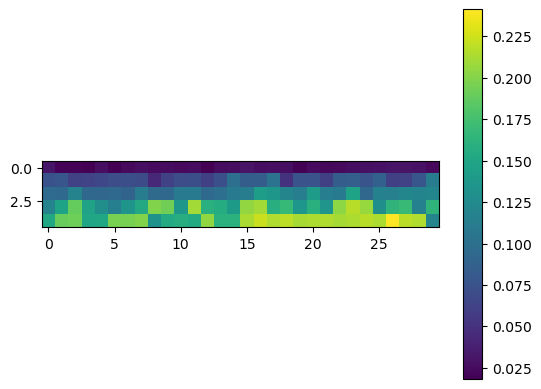

In [72]:
import seaborn as sns

plt.imshow(z, data=z)
plt.colorbar()


In [47]:
x_values

array([ 68,  37,  34, 100,  47,  13,  44,  16,  31,  96,  10,  59,  90,
        41,  93,  25,  78,  50,  22,  81,  87,  84,  56,  65,  19,  62,
        72,  28,  53,  75])

In [142]:
y_values_per_x


n_hidden
10          [1.0, 0.75, 0.5, 0.25]
25          [1.0, 0.75, 0.5, 0.25]
50          [1.0, 0.75, 0.5, 0.25]
75     [1.0, 0.75, 0.5, 0.25, 0.0]
100    [1.0, 0.75, 0.5, 0.25, 0.0]
Name: cov_ratio, dtype: object

### Specialization Gradient

In [15]:
def get_spec_gradient(**v_params):

    if v_params["n_hidden"] not in total_data["n_hidden"].unique():
        return

    v_params.pop("Step")
    print(v_params)
    ags = ["Ag 0", "Readout", "Ag 1"]
    data = filter_data(total_data, v_params)
    data_per_ts = [filter_data(data, {"Step": ts}) for ts in ["mid-", "last"]]
    data_per_ag_mean = [
        [data[[f"bottleneck_{ag}_local_diff"]] for ag in [0, "all", 1]]
        for data in data_per_ts
    ]

    diffs_ag_ts = {
        f"{ags[j]} ts {i}": data_per_ag_mean[i][j].values.squeeze()
        for i, j in [[0, 0], [1, 0], [1, 1], [1, 2], [0, 2]]
    }

    diffs_ag_ts = pd.DataFrame.from_dict(diffs_ag_ts)
    diffs_ag_ts["sparsity"] = data_per_ts[0]["sparsity"].values.squeeze()

    fig, ax = plt.subplots(figsize=(10, 5), dpi=100, constrained_layout=True)
    plot_data = data = diffs_ag_ts.groupby("sparsity").mean()
    colors = sns.color_palette(
        "husl", n_colors=len(plot_data.index.values)
    )  # get a number of colors
    cmap = dict(zip(plot_data.index.values, colors))  # zip values to colors
    plot = sns.lineplot(plot_data.T, legend=False, palette=cmap, ax=ax)

    sm = plt.cm.ScalarMappable(cmap=sns.husl_palette(as_cmap=True))
    sm.set_array([])
    fig.colorbar(sm, label="% interconnections", orientation="vertical", ax=ax)

    ax.set_xticklabels(
        [
            f"{ 'Ag' * (ag != 'Readout')} {ag} Step {t}"
            for t, ag in [[0, 0], [1, 0], [1, "Readout"], [1, 1], [0, 1]]
        ]
    )
    ax.set_ylim(-1, 1)
    ax.set_ylabel("Functional \n Specialization")
    ax.set_yticks([-1, 0, 1], ["Subtask 1", "No Spec", "Subtask 0"])

    ax.hlines(0, 0, 4, linestyles="--", colors="black", alpha=0.3)
    ax.vlines(np.arange(5), -1, 1, linestyles="--", colors="black", alpha=0.3)

    fig.show()

In [16]:
params_widgets = {
    k: widgets.Select(
        options=[p for p in params], description=k, disabled=False, value=params[0]
    )
    for k, params in varying_params.items()
}

params_widgets["n_hidden"] = widgets.IntSlider(value=25, min=10, max=100, step=5)

interactive_plot = widgets.interactive(get_spec_gradient, **params_widgets)

display(interactive_plot)

interactive(children=(Select(description='common_readout', options=(True,), value=True), Select(description='n…

In [230]:
{params[0] for k, params in varying_params.items()}

{5, False, True, 'mid-', 'parity-digits'}

# Parameter Importance

In [41]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, plot_tree

ModuleNotFoundError: No module named 'sklearn'

In [45]:
rf = RF()
metric = "bottleneck_global_diff"
metric = "best_acc"

all_features = ["n_hidden", "sparsity", "common_input", "common_readout", "task"]

fixed_features = {"task": "parity-both", "common_input": True, "common_readout": True}

# fixed_features = {}

data = s_datas[1]
remaining_features = [f for f in all_features if f not in fixed_features]
for f, f_value in fixed_features.items():
    data = filter_data(data, f, f_value)

X = data[remaining_features]
y = data[metric]

if "task" in remaining_features:
    X["task_bool"] = X["task"] == "all"
    X = X[[f for f in remaining_features if f != "task"] + ["task_bool"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rf.fit(X_train, y_train)

print(np.abs((rf.predict(X_test) - y_test)).mean())

feature_importances = lambda rf: {
    f: f_i for f, f_i in zip(rf.feature_names_in_, rf.feature_importances_)
}


0.01722677743195029


In [47]:
feature_importances(rf)

{'n_hidden': 0.899038104024546, 'sparsity': 0.10096189597545406}

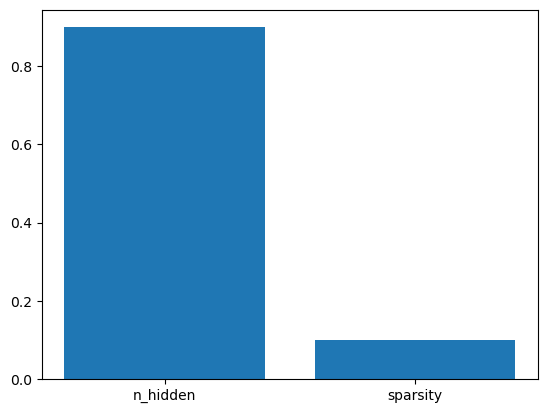

In [48]:
plt.bar(range(len(feature_importances(rf))), feature_importances(rf).values())
plt.xticks(range(len(feature_importances(rf))), list(feature_importances(rf).keys()))


# Find new metric

In [2]:
import numpy as np
import numpy.linalg as LA
from numpy.linalg import LinAlgError


In [8]:
def agent_diff(col):
    return (col[1] - col[0]) / col.sum()


def global_diff(M):
    return np.abs(agent_diff(M[:, 0]) - agent_diff(M[:, 1])) / 2


def new_metric(M):
    return np.abs(LA.det(M)) / M.sum(0).prod()

In [29]:
n_agents = 2

M = np.random.rand(n_agents, n_agents)

M = np.eye(n_agents)
M[0, 1] = 1

new_metric(M), np.abs(LA.det(M))


(0.5, 1.0)

In [128]:
idxs = [0, 2]
sub_mat = lambda M, idx: np.delete(np.delete(M, idx[0], 0), idx[1], 1).squeeze()
sub_mat(M, idxs), M

(array([[0., 1.],
        [0., 0.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

In [180]:
def reccursive_new_metric(M):
    if M.shape[0] > 2:

        res = new_metric(M)

        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                subM = sub_mat(M, [i, j])
                res += reccursive_new_metric(subM)

    else:
        res = new_metric(M)

    print(res)
    return res